In [5]:
import cv2
print(cv2.__version__)
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import skvideo.io
skvideo.setFFmpegPath('/Users/benjaminfearon/anaconda/envs/py36/lib/python3.6/site-packages')

from matplotlib.pyplot import imshow

4.2.0


In [10]:
def array_to_vid(a, output_directory, output_name):
    skvideo.io.vwrite(output_directory+output_name+".mp4", a)

def split_video(vid_list, input_dir, output_dir, segment_list, split_params, crop_list = [(150,150), (600,600), (600,600)], n_frame = 1):
    frame_dict = load_video(vid_list, input_dir, segment_list)
    train_vid, dev_vid, test_vid = np.zeros(1), np.zeros(1), np.zeros(1)

    key_list = list(frame_dict.keys())
    np.random.shuffle(key_list)

    for i in tqdm(range(len(key_list))):
        frame = frame_dict[key_list[i]]

        if(i<split_params[0]*len(key_list)):
            for j in range(n_frame):
                c_frame = find_crop(frame, crop_list[0])
                if(np.ndim(train_vid)==1):
                    train_vid = c_frame
                else:
                    train_vid = np.concatenate((train_vid, c_frame), axis=0)
            
        elif(i<(split_params[0]+split_params[1])*len(key_list)):
            for j in range(n_frame):
                c_frame = find_crop(frame, crop_list[1])
                if(np.ndim(dev_vid)==1):
                    dev_vid = c_frame
                else:
                    dev_vid = np.concatenate((dev_vid, c_frame), axis=0)
            
        else:
            for j in range(n_frame):
                c_frame = find_crop(frame, crop_list[2])
                if(np.ndim(test_vid)==1):
                    test_vid = c_frame
                else:
                    test_vid = np.concatenate((test_vid, c_frame), axis=0)
                    
    print(train_vid.shape)
    array_to_vid(train_vid, output_dir, "train_data")
    array_to_vid(dev_vid, output_dir, "dev_data")
    array_to_vid(test_vid, output_dir, "test_data")



def load_video(vid_list, input_directory, segment_list, seed = 1):
    #num_frames is a list of ints corresponding to the numbers of frames that you want to load from each clip
    #frame_start list is a list of ints corresponding to the first frame you want to load from each clip 
    #vid_list is a list of video file names without extensions (assumed to be mp4)
    frame_dict = {}
    
    for i in range(len(vid_list)):
        f_num = 3
        vidcap = cv2.VideoCapture(input_directory+vid_list[i]+".mp4")
        
        for j in tqdm(range(segment_list[i][0])):
            success, i_waste = vidcap.read()
            
        success, i1 = vidcap.read()
        success, i2 = vidcap.read()
        success, i3 = vidcap.read()
        i1, i2, i3 = np.asarray(i1), np.asarray(i2), np.asarray(i3)
        num_frames = segment_list[i][1]-segment_list[i][0]

        pbar = tqdm(total=(num_frames))
        while(success and f_num<num_frames+3):
            f_id = vid_list[i]+"_f"+str(f_num-3)
            frame_dict[f_id] = np.stack((i1,i3,i2), axis=0)
            i3 = i2
            i2 = i1
            success, i1 = vidcap.read()
            f_num+=1
            pbar.update(1)
        pbar.close()
    return frame_dict

def find_crop(frame, crop_size, display = True, verify_movement=True, attempt_max = 100, threshold = 30000):
    #frame is a matrix that should be (f_x, f_y, 3, 3) containing [F1, F3, F2] stacked along axis 4
    #crop_size is the size of the region to be used for training (d_y, d_x)
    #attempt_max is the number of attempts to find a cropped image with sufficient movement between F1 and F3
    #threshold is an arbitrary threshold for defining sufficient movement, looking for something nicer here
    
    attempts = 0
    n_fi, n_fy, n_fx, n_fc = frame.shape

    max_frame_X = []
    max_frame_Y = []
    max_mov = -1
    
    while(attempts<attempt_max):
        c_y, c_x = int(np.random.rand()*(n_fy-crop_size[0])), int(np.random.rand()*(n_fx-crop_size[1]))
        t_frame_X = frame[:-1, c_y:crop_size[0]+c_y, c_x:crop_size[1]+c_x, :]
        t_frame_Y = frame[-1, c_y:crop_size[0]+c_y, c_x:crop_size[1]+c_x, :]
        t_frame_Y = np.reshape(t_frame_Y, (1,crop_size[0], crop_size[1], n_fc))
        
        if(verify_movement==False):
            t_frame = np.concatenate((t_frame_X, t_frame_Y), axis=0)
            return t_frame
        
        mov = min(check_movement(t_frame_X[0,:,:,:], t_frame_Y[0,:,:,:]), check_movement(t_frame_X[1,:,:,:], t_frame_Y[0,:,:,:]))

        if(mov>max_mov):
            max_frame_X, max_frame_Y, max_mov = t_frame_X, t_frame_Y, mov       
        
        if(mov>threshold):
            if(display):
                show_frame(t_frame_X, t_frame_Y)
            t_frame = np.concatenate((t_frame_X, t_frame_Y), axis=0)
            return t_frame
        
        attempts+=1
        if(attempts==attempt_max):
            if(display):
                show_frame(max_frame_X, max_frame_Y)
            t_frame = np.concatenate((max_frame_X, max_frame_Y), axis=0)
            return t_frame
        
#basic motion detection for now, uses the norm of the difference of the two images
def check_movement(f1, f2):
    return np.linalg.norm(f1-f2)

def show_frame(f_x, f_y):
    plt.figure()
#     plt.imshow(np.concatenate((abs(f_x[:,:,:,0]-f_y[:,:,:]), abs(f_x[:,:,:,1]-f_y[:,:,:])), axis=1))
    plt.imshow(np.concatenate((f_x[0,:,:,:], f_y[0,:,:,:], f_x[1,:,:,:]), axis=1))
    
    


100%|██████████| 10/10 [00:00<00:00, 34.26it/s]


(24, 150, 150, 3)


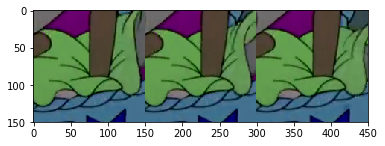

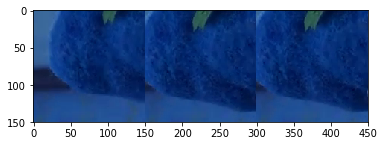

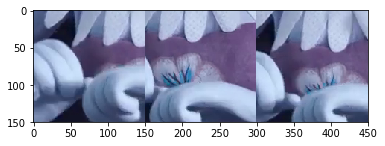

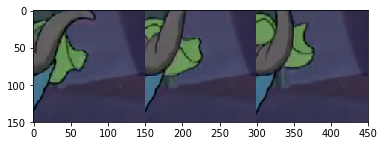

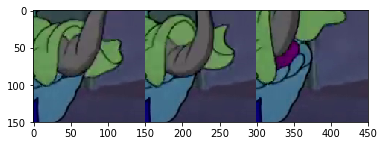

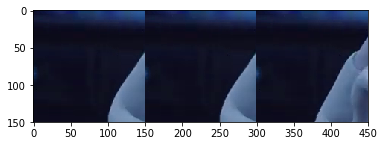

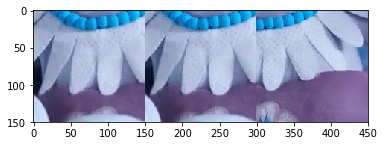

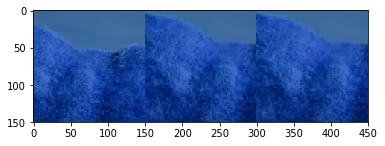

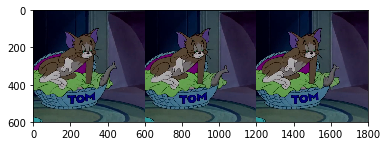

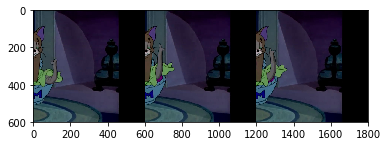

In [11]:
v_list = ["tj1", "wg"]
s_list = [(500,505), (500,505)]
split_video(v_list, "./video_data/", "./video_data/", s_list, (.8,.1,.1))

In [8]:
f_d = load_video(["train_data"], "./video_data/", [(0,15)], seed = 1)

0it [00:00, ?it/s]
100%|██████████| 15/15 [00:00<00:00, 2149.97it/s]
